# Object oriented data assimilation: application to gaussian eddies


## Introduction

### Contexte

We can think of the ocean as a sum of parametric objects such as eddies or fronts. The aim here is to illustrate the notion of object-oriented assimilation in parameter space as opposed to classical assimilation in physical space.

For the sake of simplicity, only vortices of the Gaussian form are considered in this notebook, both in the surface and in the 1D meridional section.

We define the Gaussian vortex as follows, where $h$ is the sea level, $x$ is the position, $h_0$ is the sea level at the center, $x_0$ is the position at the center and $r$ is the scale parameter, and $u$ is the zonal velocity, $f$ is the Coriolis parameter and $g$ is the gravity.


- Sea level :
  \begin{equation}
  h  = h_0 e^{-\frac{(x-x_0)^2}{2 r^2}}
  \end{equation}
- Zonal speed :  
  \begin{equation}
  u  = - \frac{g}{f} \frac{\partial h}{\partial x} = - \frac{g}{f} \frac{x-x_0}{r^2} h
  \end{equation}

Our assumption is that a deterministic model simulates eddies that are also observed by sea level anomalies.

### Objectives

The aim of this project is to investigate the effect of ensemble generation and data assimilation on very simple physical objects.

## Creation of model and observed eddies

Observed and model eddies will have the same object representation with different parameter uncertainties.

Importations

In [ ]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as scio

Parameters and reference values of the ensembles

In [ ]:
x0o = 0.  # center of obs's eddy [km]
so = 13. # std err of x for obs [km]
x0m = 40.  # center of model's eddy [km]
sm = 20. # std err of x for model [km]
ro = rm = 30.  # scale of eddies [km]
nens = 150  # ensemble size
g = 9.82  # gravity
f = 1e-4  # coriolis parameter
nx = 100  # number of grid points
xmin, xmax = -150, 200  # position bounds [km]

Graphical parameters.

In [ ]:
modcolor = "tab:blue"
objcolor = "tab:cyan"
obscolor = "tab:red"
anacolor = "tab:green"
mpl.rc("axes", grid=True)

Meridional grid for plots and classic (gridded) data assimilation.

In [ ]:
x = np.linspace(xmin, xmax, nx)

Numerical fonctions to generate $h$ and $u$ from equations (1) and (2).

In [ ]:
# SSH
def gen_h(x, x0=0, h0=1, r=1.):
    return h0*np.exp(-0.5*(x-x0)**2/r**2)

# Velocity
def gen_u(x, x0=0, h0=1, r=1.):
    return -g/f * (x-x0)/r**2 * gen_h(x, x0=x0, h0=h0, r=r) * 1e-3

Sea level and speed of reference model and observed eddies

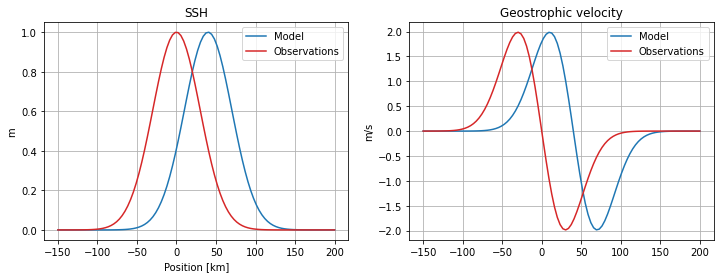

In [ ]:
hm_ref = gen_h(x, x0m, r=rm)
ho_ref = gen_h(x, x0o, r=ro)
um_ref = gen_u(x, x0m, r=rm)
uo_ref = gen_u(x, x0o, r=ro)
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)
ax[0].plot(x, hm_ref, color=modcolor, label="Model")
ax[0].plot(x, ho_ref, color=obscolor, label="Observations")
ax[0].set_xlabel("Position [km]")
ax[0].set_ylabel("m")
ax[0].legend()
ax[0].set_title("SSH")
ax[1].plot(x, um_ref, color=modcolor, label="Model")
ax[1].plot(x, uo_ref, color=obscolor, label="Observations")
ax[0].set_xlabel("Position [km]")
ax[1].set_ylabel("m/s")
ax[1].legend()
ax[1].set_title("Geostrophic velocity");

## Ensembles





### Generation

We only perturbate the the `x0` position of the model and observed gaussians.

In [ ]:
np.random.seed(0)
x0m_ens = np.random.normal(x0m, sm, nens)
x0o_ens = np.random.normal(x0o, so, nens)

Plot of gaussians.

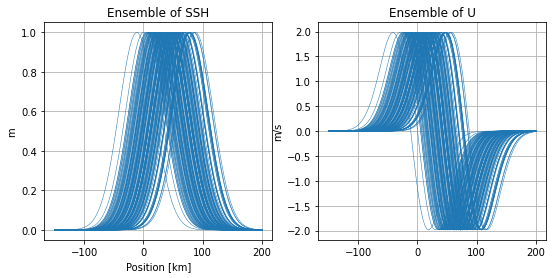

In [ ]:
hm_ens = np.array([gen_h(x, x0m, r=rm) for x0m in x0m_ens])
um_ens = np.array([gen_u(x, x0m, r=rm) for x0m in x0m_ens])
ho_ens = np.array([gen_h(x, x0o, r=ro) for x0o in x0o_ens])
uo_ens = np.array([gen_u(x, x0o, r=ro) for x0o in x0o_ens])
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
ax[0].plot(x, hm_ens.T, lw=0.5, color=modcolor)
ax[0].set_title("Ensemble of SSH")
ax[0].set_xlabel("Position [km]")
ax[0].set_ylabel("m")
ax[1].plot(x, um_ens.T, lw=0.5, color=modcolor)
ax[1].set_title("Ensemble of U")
ax[0].set_xlabel("Position [km]")
ax[1].set_ylabel("m/s");

### Means

Classical ensemble means on the grid.

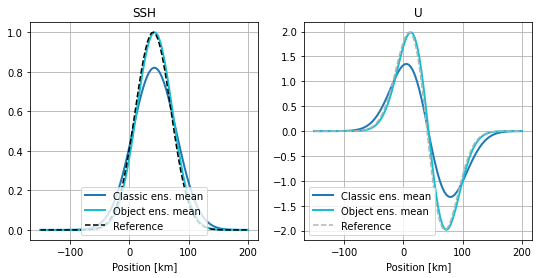

In [ ]:
hm_classic_mean = hm_ens.mean(axis=0)
um_classic_mean = um_ens.mean(axis=0)
um_object_mean = gen_u(x, x0m_ens.mean(), r=rm)
hm_object_mean = gen_h(x, x0m_ens.mean(), r=rm)
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
ax[0].plot(x, hm_classic_mean, label="Classic ens. mean", color=modcolor, lw=2)
ax[0].plot(x, hm_object_mean, label="Object ens. mean", color=objcolor, lw=2)
ax[0].plot(x, hm_ref, label="Reference", color="k", ls="--")
ax[0].set_xlabel("Position [km]")
ax[0].set_title("SSH")
ax[0].legend(loc="lower center")
ax[1].plot(x, um_classic_mean, label="Classic ens. mean", color=modcolor, lw=2)
ax[1].plot(x, um_object_mean, label="Object ens. mean", color=objcolor, lw=2)
ax[1].plot(x, um_ref, label="Reference", color='.7', ls="--")
ax[1].set_xlabel("Position [km]")
ax[1].set_title("U")
ax[1].legend(loc="lower left");

> ***Give your conlusions.***

### Physical consistency

Knowing $u$ and $h$, physical consistency is verified if the following equation is satisfied:
$$\frac{u}{h} = - \frac{g}{f} \frac{x-x_0}{r^2}$$

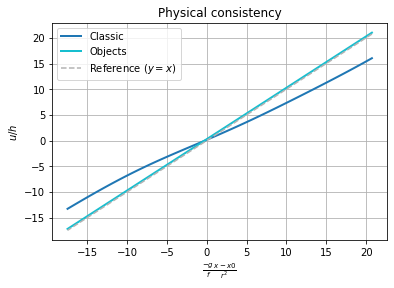

In [ ]:
plt.plot(-g/f*(x-x0m)/rm**2*1e-3, um_classic_mean/hm_classic_mean, label="Classic", color=modcolor, lw=2)
plt.plot(-g/f*(x-x0m)/rm**2*1e-3, um_object_mean/hm_object_mean, label="Objects", color=objcolor, lw=2)
plt.plot(-g/f*(x-x0m)/rm**2*1e-3, -g/f*(x-x0m)/rm**2*1e-3, color=".7", ls="--", label="Reference ($y=x$)")
plt.xlabel(r"$\frac{-g}{f}\frac{x-x0}{r^2}$")
plt.ylabel(r"$u/h$")
plt.legend()
plt.title(r"Physical consistency");

> ***Give your conclusions.***

## Analyses

A useful fonction to compute cross-covariances.

In [ ]:
def cov(m1, m2):
    m1 = m1 - m1.mean(axis=0)
    m2 = m2 - m2.mean(axis=0)
    return (m1.T@m2)/(m1.shape[0]-1)

### Classical version
In the classical analysis, we only work in the physical domain, i.e. the gridded fields.
We choose to assimilate only the sea level, but we correct both $h$ and $u$.

Packaging to form $\mathbf{X}$ with is the scaled concatenation of $h$ and $u$.


In [ ]:
scale_u2h = -f/g * rm * 1e3
hum_ens = np.hstack([hm_ens, um_ens*scale_u2h])

EnKF

In [ ]:
R = cov(ho_ens, ho_ens)
HPHt = cov(hm_ens, hm_ens)
PHt = cov(hum_ens, hm_ens)
K = PHt @ np.linalg.pinv(HPHt+R)
dhum_classic_ens = (K @ (ho_ens-hm_ens).T).T
hua_classic_ens = hum_ens + dhum_classic_ens
hua_classic_mean = hua_classic_ens.mean(axis=0)

Unpack

In [ ]:
ha_classic_ens, ua_classic_ens = np.hsplit(hua_classic_ens, [nx])
ha_classic_mean, ua_classic_mean = np.hsplit(hua_classic_mean, [nx])
ua_classic_ens /= scale_u2h
ua_classic_mean /= scale_u2h

Plot

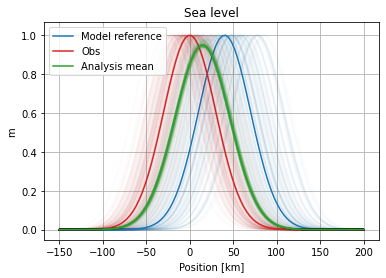

In [ ]:
plt.plot(x, hm_ens.T, color=modcolor, alpha=3/nens)
plt.plot(x, hm_ref, color=modcolor, label="Model reference")
plt.plot(x, ho_ens.T, color=obscolor, alpha=3/nens)
plt.plot(x, ho_ref, color=obscolor, label="Obs")
plt.plot(x, ha_classic_ens.T, color=anacolor, alpha=3/nens)
plt.plot(x, ha_classic_mean, color=anacolor, label="Analysis mean")
plt.title("Sea level")
plt.xlabel("Position [km]")
plt.ylabel("m")
plt.legend();



> ***Give your conclusions.
> Do not hesitate to make further diagnostics or plots to illustrate.
> You should probably plot the physical consistency.
> We have no idea of the analyzed eddy parameters:
> Can we estimate them? Implement an "observation operator" that fits a gaussian to data.***


### Object oriented version

> ***Now, rewrite the assimilation to work in the parameter space, then compare results with the classic case.***

In this context, the $\mathbf{X}$ and $\mathbf{Y}$  matrices are scalar and contain the only $x_0$, except if other parameters are perturbed.



## Perturbation of other parameters?

> ***Are the conclusions similar when the errors come from the amplitude or the scale parameters?***

## Add advection

We now introduce a minimalist forecast model $M$ through a noisy advection.
\begin{equation}
  x_0(t)  = x_0(t-1) + U dt + \epsilon_x
\end{equation}

> ***Now propagate your model eddies with the noisy advection and the observed eddies with a noise-free advection. Then perform data assimilation, both in the classic and object oriented schemes.***

Note that it is easier to propagate the eddies in the physical space by fitting its parameters and changing its position than implementing a real advection scheme.

## Apply it to 2D eddies

> ***Rewrite the equations in the horizontal plane to see real eddies!***

The gaussian in 2D: https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function

Sea level $h$:

\begin{align}
h &= h_0 e^{-a (x-x_0)^2 +b (x-x_0)(y-y_0) - c (y-y_0)^2}\\
a &= \frac{\cos^2\theta}{2r_a^2} + \frac{\sin^2\theta}{2r_b^2}\\
b &= -\frac{\sin^2 2\theta}{2r_a^2} + \frac{\sin^2 2\theta}{2r_b^2}\\
c &= \frac{\sin^2\theta}{2r_a^2} + \frac{\cos^2\theta}{2r_b^2}\\
\end{align}

Gostrophiques velocities:

\begin{align*}
u_{geo} &= -\frac{g}{f} \frac{\partial h}{\partial y} = 2\frac{g}{f} * (-b (x-x_0) + c (y-y_0)) h\\
v_{geo} &= \frac{g}{f} \frac{\partial h}{\partial x} = -2\frac{g}{f} * (a (x-x_0) - b (y-y_0)) h\\
\end{align*}

The location of maximal velocities are an ellipse with semi-major axis $r_a$ et semi-minor axis $r_b$.


For simplicity, assume that you are in a plane with coordinates in meters and at a fixed latitude for the coriolis parameter.



Generator function:

In [ ]:
def gen_gaussian_eddy(xx, yy, h0, x0, y0, ra, rb, theta):
    """Generate a rotated elliptic eddy on the grid

    xx,yy: 1d arrays of coordinates
    h0,x0,y0,ra,rb,theta: eddy parameters
    """
    thetar = radians(theta)
    a = 0.5 * (cos(thetar)**2/ra**2 + sin(thetar)**2/rb**2)
    b = 0.25 * (-sin(2*thetar)/ra**2 + sin(2*thetar)/rb**2)
    c = 0.5 * (sin(thetar)**2/ra**2 + cos(thetar)**2/rb**2)
    dx = x0 - xx
    dy = y0 - yy
    h = h0 * exp(-(a*dx**2 - 2*b*(dx*dy) + c*dy**2))
    u = 2 * g / f * (-b*dx + c*dy) * h
    v = -2 * g / f * (a*dx - b*dy) * h
    return h, u, v

## Apply to real world data

Data sample : https://drive.google.com/file/d/1FTjKAxWMx9m39hCcEgl7FyP9R5kZqzoe/view?usp=sharing

Copy this file to your own drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Open the file with xarray by changing the path with your own path.

In [ ]:
import xarray as xr
ds = xr.open_dataset("/content/drive/MyDrive/Cours/Assimilation/Data/mercator.ssh.nc")
ds

<xarray.Dataset>
Dimensions:    (latitude: 55, time: 31, longitude: 61)
Coordinates:
  * latitude   (latitude) float32 48.5 48.58 48.67 48.75 ... 52.83 52.92 53.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-31T12:00:00
  * longitude  (longitude) float32 -28.0 -27.92 -27.83 ... -23.17 -23.08 -23.0
Data variables:
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

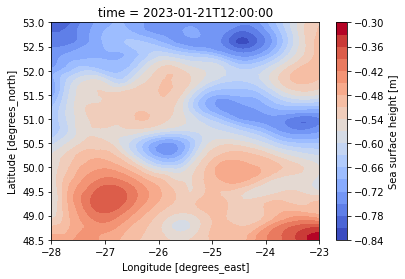

In [ ]:
ssh = ds.zos
ssh[20].plot.contourf(cmap="coolwarm", levels=20);

Use the time steps 0 to 19 to build an ensemble of anomalies, use the time step 20  as a first guess and make an analysis with time step 30.

## Conclusions

> ***What are your overall conclusions and recommandations ? Do you have any suggestion to improve data assimilation systems at mesoscales ?***